# DATA 271 Final Project: US Homelessness

Homelessness in America, and specifically in California, is a major issue that affects hundreds of thousands of people. I would like to look into the data involving homelessness and see how many people are affected. I think that, through looking at trends in this data, I can try to look at real life situations and causes that might be affecting these trends. Such examples could include policies and legislations, and other potential socioeconomic factors.
If I can see potentially correlating factors in homeless population trends, I may be able to link them to outside circumstances and suggest potential changes.

This data informs policymakers as to how to delegate help to homeless populations, so it is important to understand it to get the proper funding.

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install openpyxl
!pip install pyxlsb

In [116]:
import warnings
warnings.filterwarnings('ignore')

-  **numpy**: For any calculations I may need to do.
-  **pandas**: For importing data and utilizing it in a dataframe.
-  **matplotlob**: For visualizing data.
-  **seaborn**: For visualizing data.
__________________________________________________________


-  **pit_counts_df** (https://www.huduser.gov/portal/sites/default/files/xls/2007-2024-PIT-Counts-by-State.xlsb): This is a dataset of Point-In-Time (PIT) estimates by states in the United States, from 2007 to 2024. Point-In-Time count is an effort led by the U.S. Department of Housing and Urban Development, also known as HUD, that estimates the number of homeless people in the United States. I will be looking at the years 2014-2024.
-  This dataset has hundreds, and sometimes over a thousand variables, so I will need to narrow them down to the most relevant ones. I'll be looking at various aspects, such as the gender of these homeless individuals, how many are sheltered compared to on the streets, and more.
_____________________________

-  **hic_counts_df** (https://www.huduser.gov/portal/sites/default/files/xls/2007-2024-HIC-Counts-by-State.xlsx): This is a dataset of Housing Inventory Counts (HIC) by states in the United States, from 2007 to 2024. HIC is an inventory count system used within a CoC that provides beds dedicated to serving homeless people. I will be looking at the years 2014-2024.
-  This dataset has many variables dedicated to bed counts, unit counts, specific categories for children, adults, veterans, etc.
- Some categories of beds include **ES (emergency shelter), TH (transitional housing), SH (safe haven), and OPH (other permanent housing).**
__________________________________________________________
  
# Preparing the datasets

In [117]:
# importing the datasets I will be working with

pit_counts_df = pd.read_excel('2007-2024-PIT-Counts-by-State.xlsb', engine='pyxlsb', sheet_name=None)

hic_counts_df = pd.read_excel('2007-2024-HIC-Counts-by-State.xlsx', engine='openpyxl', sheet_name=None,header=None)

In [118]:
# making copies of the raw datasets

base_pit_copy = pit_counts_df.copy()
base_hic_copy = hic_counts_df.copy()

In [119]:
# cleaning up the headers in hic_counts_df

with pd.ExcelFile('2007-2024-HIC-Counts-by-State.xlsx') as excel:
    hic_dict = pd.read_excel(excel, sheet_name=None, header=None)

processed_sheets = {}
for sheet_name, df in hic_dict.items():
    header_row = 1 
    if len(df) > header_row: 
        df.columns = df.iloc[header_row].values
        df = df.drop([0, 1]).reset_index(drop=True)
        processed_sheets[sheet_name] = df.drop(header_row).reset_index(drop=True)
    else:
        processed_sheets[sheet_name] = df 

with pd.ExcelWriter('2007-2024-HIC-Counts-by-State-modified.xlsx') as writer:
    for sheet_name, df in processed_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

In [120]:
# creating a new .xlsx file with the edited headers

hic_counts_df = pd.read_excel('2007-2024-HIC-Counts-by-State-modified.xlsx', engine='openpyxl', sheet_name=None)

In [121]:
# reducing the pit_counts_df dataset to the years 2014-2024

pit_decade = list(pit_counts_df.items())[:11]

updated_dfs_pit = []

for sheet_name, df in pit_decade:
    year = int(sheet_name)
    df["Year"] = year
    updated_dfs_pit.append(df) 

# combining each dataset now that each row denotes the year
pit_concat_df = pd.concat(updated_dfs_pit, ignore_index=True) 

In [122]:
# reducing the hic_counts_df dataset to the years 2014-2024

hic_decade = list(hic_counts_df.items())[:11]

updated_dfs_hic = []

for sheet_name, df in hic_decade:
    year = int(sheet_name)
    df["Year"] = year
    updated_dfs_hic.append(df) 

# combining each dataset now that each row denotes the year
hic_concat_df = pd.concat(updated_dfs_hic, ignore_index=True) 

_______________________________________________________________________________
# Point in Time Counts

In [123]:
# narrowing down the PIT dataset to count the totals

from gender_drop import gender_drop
pit_totals_gender = pit_concat_df.drop(columns=gender_drop)

In [124]:
# converting null values to 0 to make them workable

pit_totals_gender = pit_totals_gender.replace({pd.NA: 0, '': 0, None: 0}).fillna(0)

In [125]:
# creating a dataframe representing the total of each column for each year

gender_only_totals = pit_totals_gender.loc[pit_totals_gender['State'] == 'Total']

In [126]:
# aggregating the columns representing non-cisgender identities

test = gender_only_totals[['Overall Homeless Individuals - Transgender',
 'Overall Homeless Individuals - Gender Questioning',
 'Overall Homeless Individuals - Culturally Specific Identity',
 'Overall Homeless Individuals - Different Identity',
 'Overall Homeless Individuals - Non Binary',
 'Overall Homeless Individuals - More Than One Gender','Year']]

In [127]:
# adding each row together in order to get a total amount 
# of non-cisgender homeless individuals per year

noncis_columns = [col for col in test.columns if col.startswith('Overall Homeless Individuals')]
test['Overall Homeless Non-Cisgender Individuals'] = test[noncis_columns].sum(axis=1)

In [128]:
# getting the column ready to merge into the overall total dataframe

to_merge = test.drop(columns=['Overall Homeless Individuals - Transgender',
 'Overall Homeless Individuals - Gender Questioning',
 'Overall Homeless Individuals - Culturally Specific Identity',
 'Overall Homeless Individuals - Different Identity',
 'Overall Homeless Individuals - Non Binary',
 'Overall Homeless Individuals - More Than One Gender'])

In [129]:
# merging the dataframe
gender_only_totals = pd.merge(gender_only_totals, to_merge)
# getting the percentage of overall non-cisgender homeless individuals 
gender_only_totals['Non-Cisgender %'] = gender_only_totals['Overall Homeless Non-Cisgender Individuals'] / gender_only_totals['Overall Homeless Individuals'] * 100
# pushing the year column to the end of the dataframe
gender_only_totals = gender_only_totals[[col for col in gender_only_totals.columns if col != 'Year'] + ['Year']]

_____________________________________________________________________________

# Visualizing the PIT count data
When looking at the columns for the PIT count dataframe, I became interested in checking out the counts of homeless individuals who are not cisgender. For this, I decided to add the total counts of the transgender, gender questioning, culturally specific identity, different identity, non binary, and more than one gender columns. There are other ways these identities could be described as one group, but I wanted to look at it under the lens of "these are not self identified 'men' or 'women.'"
  
It is important to note that when I refer to "individuals," the data is referring to single people who are homeless, that aren't otherwise a part of a family with other homeless individuals.

Text(0, 0.5, 'Overall population')

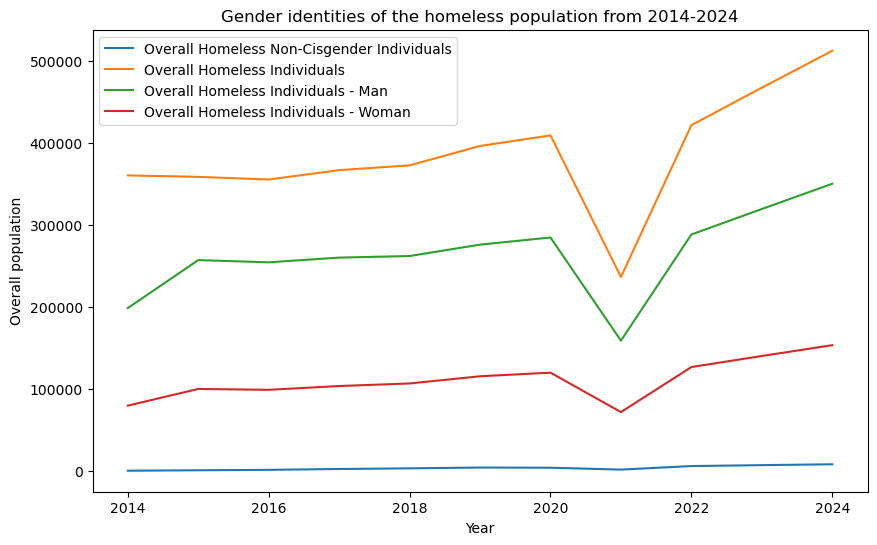

In [130]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=gender_only_totals, 
            x='Year', 
            y='Overall Homeless Non-Cisgender Individuals',
            label='Overall Homeless Non-Cisgender Individuals')
sns.lineplot(data=gender_only_totals, 
            x='Year', 
            y='Overall Homeless Individuals',
            label='Overall Homeless Individuals')
sns.lineplot(data=gender_only_totals, 
            x='Year', 
            y='Overall Homeless Individuals - Man',
            label='Overall Homeless Individuals - Man')
sns.lineplot(data=gender_only_totals, 
            x='Year', 
            y='Overall Homeless Individuals - Woman',
            label='Overall Homeless Individuals - Woman')

plt.title('Gender identities of the homeless population from 2014-2024')
plt.xlabel('Year')
plt.ylabel('Overall population')

In comparing these populations, I wanted to see what the ratio was between them. Before I even noted the difference between the plotted lines, I saw the drastic dip in the year 2021. We'll look into this further down the line, but for now I want to compare these categories.    
    
As you can see, non-cisgender individuals only make up **1.66%** of the total population of homeless individuals as of 2024, and even less in previous years. It is important to remember that the overall population of transgender people represents around 1% of the total US population. According to the [USAFacts calculations using Census Bureau data collected in 2024](https://usafacts.org/articles/what-percentage-of-the-us-population-is-transgender/), this makes up about **2.3 million people.**   
__________________________________________________________________________  
With that being said, I would like to take a closer look at how the number of homeless individuals who do not identify as cisgender has evolved over the last decade.

Text(0.5, 1.0, 'Count of non-cisgender homeless individuals from 2014-2024')

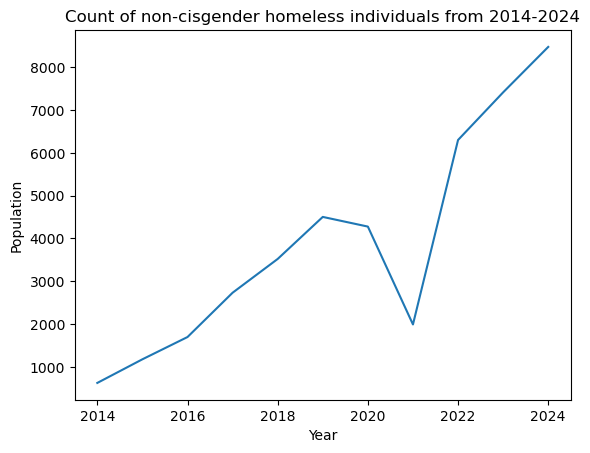

In [131]:
# creating a line plot to demonstrate
sns.lineplot(data=gender_only_totals, 
            x='Year', 
            y='Overall Homeless Non-Cisgender Individuals',
            )

plt.ylabel('Population')
plt.title('Count of non-cisgender homeless individuals from 2014-2024')

When we take a closer look at the population of non-cisgender homeless individuals over the last decade, we can observe that there is a **substantial** increase, as you will see in my calculations.
  
  
The rate at which homelessness has grown in the United States is alarming. Non-cisgender identities have become more visible in the US in the last decade, and so has the amount of these individuals on the streets. 
  
  
According to the [Trans Legislation Tracker](https://translegislation.com/learn), there has been a surge in **anti-trans** legislation in the United States in the last 10 years. Specifically from 2015-2025, there have been a total of 2774 anti-trans bills considered in the United States, **690** of which were pertaining to healthcare. In 2024, 51 of these bills passed on a state-wide level in 17 states, while 88 bills were passed on a national level.
  
  
This demographic being targeted so heavily by policymakers raises concerns of this steep increase of non-cisgender homeless individuals increasing further, and at an even more rapid rate than ever. Just in the last few years, the presented anti-trans legislation has surged like we have never seen before. In 2022 there were 174 bills presented, and in 2023 this number jumped to **615**. 

________________

# Let's take a closer look at the count of overall homeless individuals in the last decade: 

Text(0.5, 1.0, 'Overall Count of homeless individuals from 2014-2024')

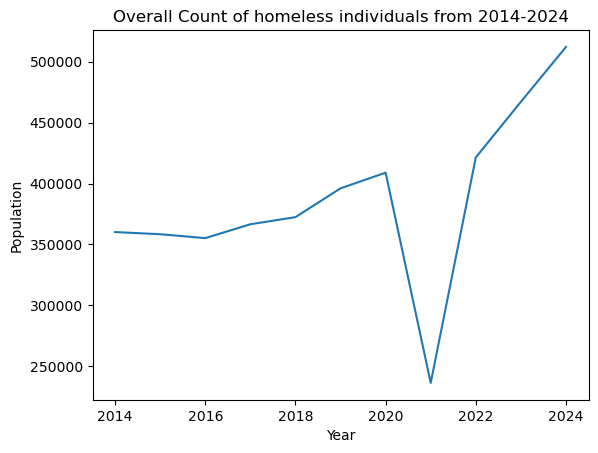

In [132]:
# creating a line plot to visualize the evolving population

sns.lineplot(data=gender_only_totals, 
             x='Year', 
             y='Overall Homeless Individuals',
             label='')
plt.ylabel('Population')
plt.title('Overall Count of homeless individuals from 2014-2024')

I want to start off with that large dip that we've seen in each category we've looked at so far. Why is there such a steep decrease in population count in 2021? According to the HUD's [Annual Homelessness Assessment Report for 2021](https://www.huduser.gov/portal/datasets/ahar/2021-ahar-part-1-pit-estimates-of-homelessness-in-the-us.html), HUD encouraged caution in conducting unsheltered PIT counts in response to the COVID-19 pandemic. They did not want the CoC's to risk furthering the spread of COVID-19 due to the lack of widespread vaccinations to prevent the illness. Because of this, there is a significant gap in information surrounding that year.
  
Now that the dip has been addressed, I want to look at the upward trend in overall homeless population. The only time there was any decrease in population (ignoring the anomaly that was 2021) was between the years 2014 and 2016, where it was slightly decreasing. After that, there was quite a large increase.
  
I will now calculate the increase for each of the populations we have observed so far:

In [133]:
# calculating the difference in overall homeless individuals from 2014 and 2024

overall_flat_diff = gender_only_totals['Overall Homeless Individuals'][0] - gender_only_totals['Overall Homeless Individuals'][10]
overall_percent_increase = np.round((overall_flat_diff / gender_only_totals['Overall Homeless Individuals'][10]) * 100, 2)

man_flat_diff = gender_only_totals['Overall Homeless Individuals - Man'][0] - gender_only_totals['Overall Homeless Individuals - Man'][10]
man_percent_increase = np.round((man_flat_diff / gender_only_totals['Overall Homeless Individuals - Man'][10]) * 100, 2)

woman_flat_diff = gender_only_totals['Overall Homeless Individuals - Woman'][0] - gender_only_totals['Overall Homeless Individuals - Woman'][10]
woman_percent_increase = np.round((woman_flat_diff / gender_only_totals['Overall Homeless Individuals - Woman'][10]) * 100, 2)

noncis_flat_diff = gender_only_totals['Overall Homeless Non-Cisgender Individuals'][0] - gender_only_totals['Overall Homeless Non-Cisgender Individuals'][10]
noncis_percent_increase = np.round((noncis_flat_diff / gender_only_totals['Overall Homeless Non-Cisgender Individuals'][10]) * 100, 2)


print('The population of overall male homeless individuals increased by ' + str(man_flat_diff) + 
      ' people from 2014 to 2024, which is an increase of ' + str(man_percent_increase) + ' percent.\n')

print('The population of overall female homeless individuals increased by ' + str(woman_flat_diff) + 
      ' people from 2014 to 2024, which is an increase of ' + str(woman_percent_increase) + ' percent.\n')

print('The population of overall non-cisgender homeless individuals increased by ' + str(noncis_flat_diff) + 
      ' people from 2014 to 2024, which is an increase of ' + str(noncis_percent_increase) + ' percent.\n')

print('The population of overall homeless individuals increased by ' + str(overall_flat_diff) + 
      ' people from 2014 to 2024, which is an increase of ' + str(overall_percent_increase) + ' percent.\n')

The population of overall male homeless individuals increased by 151418 people from 2014 to 2024, which is an increase of 76.23 percent.

The population of overall female homeless individuals increased by 73610 people from 2014 to 2024, which is an increase of 92.17 percent.

The population of overall non-cisgender homeless individuals increased by 7849 people from 2014 to 2024, which is an increase of 1255.84 percent.

The population of overall homeless individuals increased by 151818 people from 2014 to 2024, which is an increase of 42.15 percent.



Overall, homelessness has **increased a great amount** for all of these populations over the last decade. The biggest demographic of homeless individuals are male, but the growth has not been as steep as female and non-cisgender individuals. Specifically, non-cisgender homeless individuals have seen a drastic increase in the last decade, amounting to around **1256%.** Moving forward, I would like to look at the statistics of sheltered homeless people.

___

# Housing Inventory Counts

**HIC (Housing Inventory Count)** refers to a point-in-time inventory count from within a continuum of care, which counts beds and units which are used to serve people who are experiencing homelessness. This dataset tracks all beds in shelters, including ones for domestic violence victims and permanent housing. For my observations, I will be looking at **HMIS (Homeless Management Information Systems)** tracked beds. This will insure that the beds being observed will more likeley be relevant to my topic of research. I will also be narrowing the data down further, only observing SH, ES, and TH beds. These abbreviations stand for **Safe Haven**, **Emergency Shelter**, and **Transitional Housing** respectively. 
  
Some other categories I will not be observing **OPH**, **PSH**, and **RRH** beds, which are abbreviations for **Other Permanent Housing**, **Permanent Supportive Housing**, and **Rapid Re-housing** respectively. There is an important distinction to be made between these categories of beds compared to the ones that I will be observing. These beds represent permanent housing, which does not fit within my line of research.

In [134]:
hic_concat_df

,State,"Total Year-Round Beds (ES, TH, SH)","Total Non-DV Year-Round Beds (ES, TH, SH)","Total HMIS Year-Round Beds (ES, TH, SH)","HMIS Participation Rate for Year-Round Beds (ES, TH, SH)",Total Year-Round Beds (ES),Total Year-Round Beds (TH),Total Year-Round Beds (SH),"Total Units for Households with Children (ES, TH, SH)","Total Beds for Households with Children (ES, TH, SH)",...,Total Beds for Households without Children (RRH & DEM),Total Beds for Households with only Children (RRH & DEM),Total Year-Round Beds (DEM),Total Non-DV Year-Round Beds (DEM),Total HMIS Year-Round Beds (DEM),HMIS Participation Rate for Year-Round Beds (DEM),Total Units for Households with Children (DEM),Total Beds for Households with Children (DEM),Total Beds for Households without Children (DEM),Total Beds for Households with only Children (DEM)
0,AK,2039,1456,1200,0.5885,1438,601,0,225,802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AR,2036,1466,980,0.4813,1579,457,0,261,850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AZ,8884,8026,7654,0.8615,6967,1831,86,1183,3330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CA,75938,72310,64451,0.8487,61387,14078,473,8906,25915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CO,11392,10870,9407,0.8258,8215,3114,63,2351,4707,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,WA,14886,13265,10157,0.6823,7209,7632,45,2540,8588,...,1457.0,2.0,29.0,0.0,0.0,0,8.0,27.0,2.0,0.0
598,WI,6504,5218,4635,0.7126,3436,3004,64,1246,3859,...,72.0,0.0,13.0,13.0,13.0,1,4.0,13.0,0.0,0.0
599,WV,1965,1644,1293,0.658,1363,589,13,243,822,...,29.0,2.0,0.0,0.0,0.0,.,0.0,0.0,0.0,0.0
600,WY,815,613,338,0.4147,445,370,0,134,375,...,15.0,0.0,0.0,0.0,0.0,.,0.0,0.0,0.0,0.0


In [135]:
# importing a large list of columns to drop

from hic_drop import hic_drop

In [136]:
# dropping the columns

hic_totals = hic_concat_df.drop(columns=hic_drop)
hic_totals = hic_totals.drop(columns=['HMIS Participation Rate for Year-Round Beds (ES, TH, SH)', 'Total HMIS Year-Round Beds (PSH)', 'Total HMIS Year-Round Beds (OPH)'])

In [137]:
# creating the dataframe for total beds nationwide for each year

hic_year_totals = hic_totals.loc[hic_totals['State'] == 'Total'].drop(columns='State').astype(int).reset_index()
hic_year_totals = hic_year_totals.drop(columns='index')

In [138]:
# creating a dataframe of sheltered homeless individuals

from pit_sheltered_drop import pit_sheltered_drop
pit_sheltered_df = pit_concat_df.drop(columns=pit_sheltered_drop)

In [139]:
# preparing a dataframe of sheltered homeless individuals to merge with hic_year_totals

pit_sheltered_totals = pit_sheltered_df.loc[pit_sheltered_df['State'] == 'Total'].drop(columns='State').astype(int).reset_index()
pit_sheltered_totals = pit_sheltered_totals.drop(columns='index')

# merging the two dataframes 
hic_with_individuals = pd.merge(hic_year_totals, pit_sheltered_totals)
hic_with_individuals = pd.merge(hic_with_individuals, gender_only_totals[['Overall Homeless Individuals','Year']])
# calculating how many unsheltered homeless individuals there are
hic_with_individuals['Unsheltered Total Homeless Individuals'] = hic_with_individuals['Overall Homeless Individuals'] - hic_with_individuals['Sheltered Total Homeless Individuals']
hic_with_individuals['Percent Unsheltered Total Homeless Individuals'] = (hic_with_individuals['Unsheltered Total Homeless Individuals'] / hic_with_individuals['Overall Homeless Individuals']) * 100
# pushing the year column to the end

hic_with_individuals = hic_with_individuals[[col for col in hic_with_individuals.columns if col != 'Year'] + ['Year']]
hic_with_individuals

,"Total HMIS Year-Round Beds (ES, TH, SH)",Total HMIS Year-Round Beds (ES),Total HMIS Year-Round Beds (TH),Total HMIS Year-Round Beds (SH),Sheltered ES Homeless Individuals,Sheltered SH Homeless Individuals,Sheltered Total Homeless Individuals,Overall Homeless Individuals,Unsheltered Total Homeless Individuals,Percent Unsheltered Total Homeless Individuals,Year
0,391588,333705,55678,2205,218540,1948,256340,512007,255667,49.934278,2024
1,343130,283828,57066,2236,188390,2028,227795,467020,239225,51.223716,2023
2,312543,252866,57379,2298,168717,1743,204897,421392,216495,51.376153,2022
3,295709,237344,56175,2190,159205,1683,194749,236483,41734,17.64778,2021
4,286968,224659,60133,2176,156847,1986,199478,408891,209413,51.214871,2020
5,280244,214680,63389,2175,156673,1933,199531,396045,196514,49.619109,2019
6,276147,206342,67490,2315,148764,1947,194340,372417,178077,47.81656,2018
7,290151,204472,84225,1454,140843,1463,193144,366585,173441,47.312629,2017
8,299081,190715,106584,1782,138311,1686,198008,355212,157204,44.256388,2016
9,302818,183641,117297,1880,139970,1861,205616,358422,152806,42.632986,2015


<Axes: >

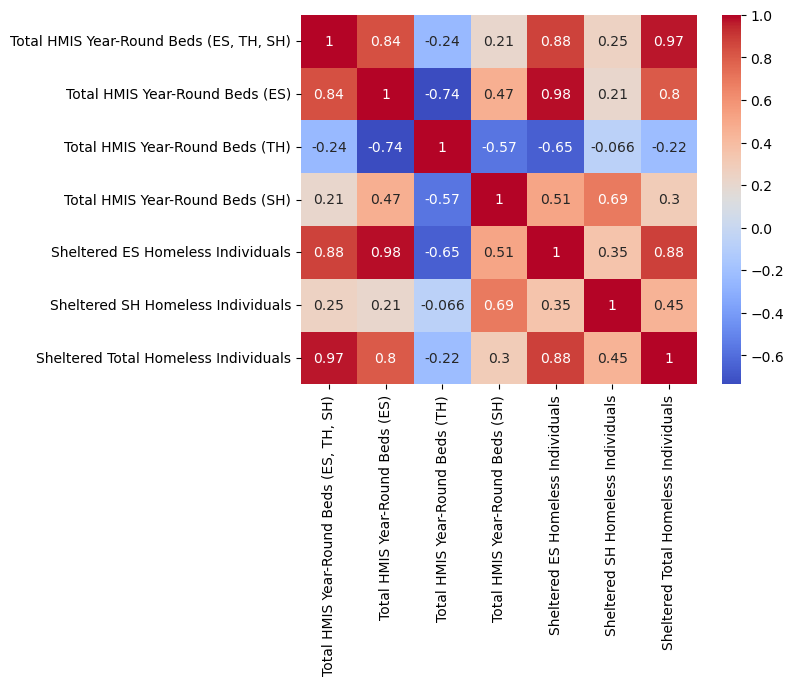

In [140]:
# testing the correlation between beds and individuals
#  to see how close they are in relation

hic_corr = hic_with_individuals.drop(columns=['Year',
                                              'Unsheltered Total Homeless Individuals',
                                             'Percent Unsheltered Total Homeless Individuals',
                                             'Overall Homeless Individuals']).corr()
sns.heatmap(hic_corr,annot=True,cmap='coolwarm')

The main thing I wanted to see was how sheltered total homeless individuals correlated with the total HMIS year-round beds, and it correlates very closely. The respective categories of individuals mostly correlates as well.
___________
Lastly for the nationwide level, I want to compare the amount of unsheltered homeless individuals to sheltered homeless individuals.

In [141]:
# reshaping the dataframe to be used in the visualization

long = hic_with_individuals.drop(columns=['Total HMIS Year-Round Beds (ES, TH, SH)',
                                          'Total HMIS Year-Round Beds (ES)',
                                          'Total HMIS Year-Round Beds (TH)',
                                          'Total HMIS Year-Round Beds (SH)',
                                          'Sheltered ES Homeless Individuals',
                                          'Sheltered SH Homeless Individuals',
                                          'Percent Unsheltered Total Homeless Individuals',
                                          'Overall Homeless Individuals'])
long = long.melt(id_vars='Year', value_vars=['Sheltered Total Homeless Individuals',
                                             'Unsheltered Total Homeless Individuals'],
                 var_name = 'Category', value_name = 'Number of Homeless Individuals')

Text(0.5, 1.0, 'Comparison between sheltered and unsheltered homeless individuals')

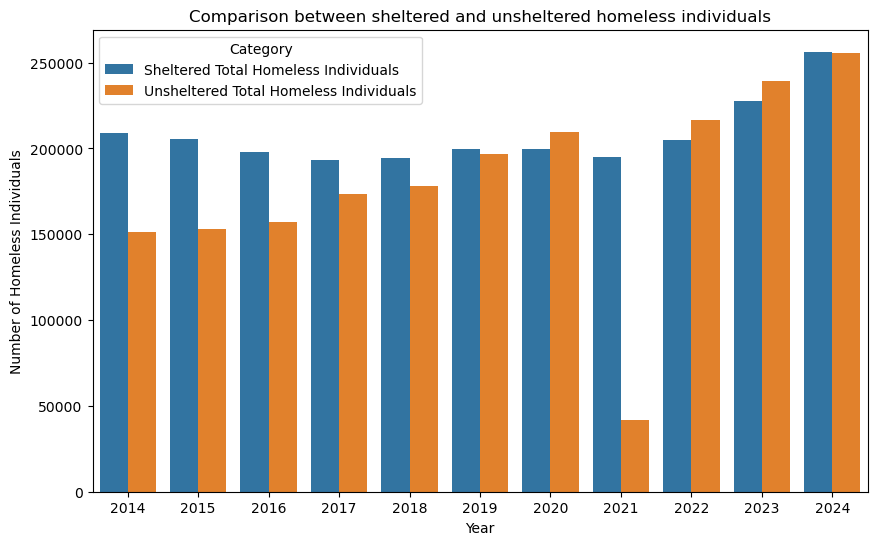

In [142]:
plt.figure(figsize=(10, 6))
sns.barplot(data=long,x='Year',y='Number of Homeless Individuals',hue='Category')
plt.title('Comparison between sheltered and unsheltered homeless individuals')

In [143]:
hic_with_individuals[['Year','Percent Unsheltered Total Homeless Individuals']]

,Year,Percent Unsheltered Total Homeless Individuals
0,2024,49.934278
1,2023,51.223716
2,2022,51.376153
3,2021,17.64778
4,2020,51.214871
5,2019,49.619109
6,2018,47.81656
7,2017,47.312629
8,2016,44.256388
9,2015,42.632986


In [144]:
avg_decade_unsheltered_percent = sum(hic_with_individuals['Percent Unsheltered Total Homeless Individuals']) / 11

print('The average percentage of unsheltered homeless individuals from 2014 to 2024 is ' + str(np.round(avg_decade_unsheltered_percent,2)) + '%.')

The average percentage of unsheltered homeless individuals from 2014 to 2024 is 45.0%.


Throughout the last decade, unsheltered homeless individuals on average have made up about 45 percent of the population of overall homeless individuals. This might suggest that there should be more CoCs in order to shelter more homeless people. This would require more funding to make a possibility.

___
# Nationwide Conclusions
  
- Homelessness in the United States is steadily rising, increasing year after year
  
- The overall population of homeless individuals has increased by 42.15 percent from 2014 to 2024
  
- The population of non-cisgender homeless individuals has increased by 1255.84 percent from 2014 to 2024. 
  - There has been a rise in anti-LGBTQ+ legislation in the last decade, which could potentially be a factor in the steep rise in non-cisgender homelessness. Protections against this type of harmful legislation could potentially lead to a decrease in this growth.
  
- HMIS has been increasing their beds in shelters over the years, however the average percent of unsheltered homeless individuals amounted to 45 percent of the population of homeless individuals. 
  - This might suggest that there should be more CoCs in order to house more of the unsheltered homeless individuals. This would require more funding and manpower.

___
# California analysis
  
Now I'd like to take a look at the same metrics we looked at on the nationwide scale, but narrowed down to California.

In [158]:
# recreating the pit count dataframe for California
california_gender_totals = pit_totals_gender.loc[pit_totals_gender['State'] == 'CA']

test3 = california_gender_totals[['Overall Homeless Individuals - Transgender',
                             'Overall Homeless Individuals - Gender Questioning',
                             'Overall Homeless Individuals - Culturally Specific Identity',
                             'Overall Homeless Individuals - Different Identity',
                             'Overall Homeless Individuals - Non Binary',
                             'Overall Homeless Individuals - More Than One Gender','Year']]
noncis_columns_ca = [col for col in test3.columns if col.startswith('Overall Homeless Individuals')]
test3['Overall Homeless Non-Cisgender Individuals'] = test3[noncis_columns_ca].sum(axis=1)
ca_to_merge = test3.drop(columns=['Overall Homeless Individuals - Transgender',
                                  'Overall Homeless Individuals - Gender Questioning',
                                  'Overall Homeless Individuals - Culturally Specific Identity',
                                  'Overall Homeless Individuals - Different Identity',
                                  'Overall Homeless Individuals - Non Binary',
                                  'Overall Homeless Individuals - More Than One Gender'])
ca_gender_totals = pd.merge(california_gender_totals, ca_to_merge)
ca_gender_totals['Non-Cisgender %'] = ca_gender_totals['Overall Homeless Non-Cisgender Individuals'] / ca_gender_totals['Overall Homeless Individuals'] * 100
ca_gender_totals = ca_gender_totals[[col for col in gender_only_totals.columns if col != 'Year'] + ['Year']]

Text(0, 0.5, 'Overall population')

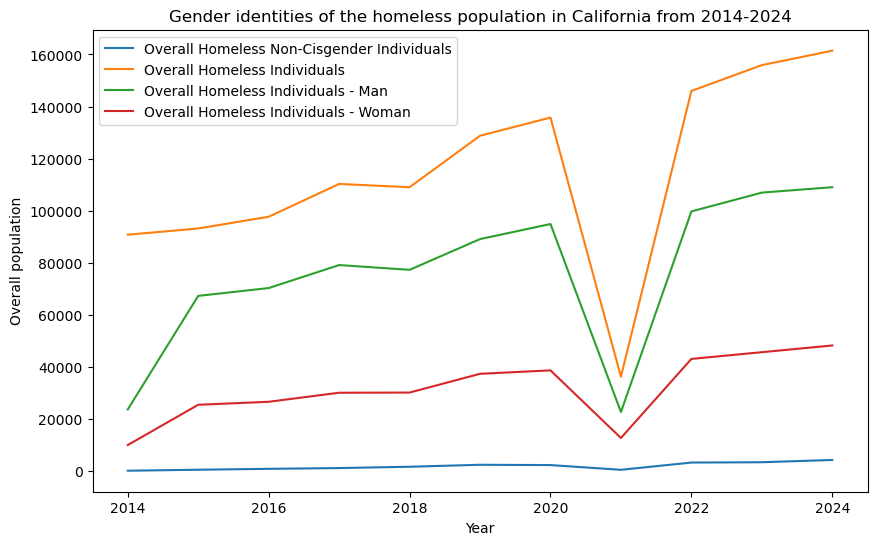

In [159]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=ca_gender_totals, 
            x='Year', 
            y='Overall Homeless Non-Cisgender Individuals',
            label='Overall Homeless Non-Cisgender Individuals')
sns.lineplot(data=ca_gender_totals, 
            x='Year', 
            y='Overall Homeless Individuals',
            label='Overall Homeless Individuals')
sns.lineplot(data=ca_gender_totals, 
            x='Year', 
            y='Overall Homeless Individuals - Man',
            label='Overall Homeless Individuals - Man')
sns.lineplot(data=ca_gender_totals, 
            x='Year', 
            y='Overall Homeless Individuals - Woman',
            label='Overall Homeless Individuals - Woman')

plt.title('Gender identities of the homeless population in California from 2014-2024')
plt.xlabel('Year')
plt.ylabel('Overall population')

In [160]:
# calculating the difference in overall homeless individuals from 2014 and 2024

overall_flat_diff_ca = ca_gender_totals['Overall Homeless Individuals'][0] - ca_gender_totals['Overall Homeless Individuals'][10]
overall_percent_increase_ca = np.round((overall_flat_diff_ca / ca_gender_totals['Overall Homeless Individuals'][10]) * 100, 2)

man_flat_diff_ca = ca_gender_totals['Overall Homeless Individuals - Man'][0] - ca_gender_totals['Overall Homeless Individuals - Man'][10]
man_percent_increase_ca = np.round((man_flat_diff_ca / ca_gender_totals['Overall Homeless Individuals - Man'][10]) * 100, 2)

woman_flat_diff_ca = ca_gender_totals['Overall Homeless Individuals - Woman'][0] - ca_gender_totals['Overall Homeless Individuals - Woman'][10]
woman_percent_increase_ca = np.round((woman_flat_diff_ca / ca_gender_totals['Overall Homeless Individuals - Woman'][10]) * 100, 2)

noncis_flat_diff_ca = ca_gender_totals['Overall Homeless Non-Cisgender Individuals'][0] - ca_gender_totals['Overall Homeless Non-Cisgender Individuals'][10]
noncis_percent_increase_ca = np.round((noncis_flat_diff_ca / ca_gender_totals['Overall Homeless Non-Cisgender Individuals'][10]) * 100, 2)

print('The population of overall male homeless individuals increased by ' + str(man_flat_diff_ca) + 
      ' people from 2014 to 2024, which is an increase of ' + str(man_percent_increase_ca) + ' percent.\n')

print('The population of overall female homeless individuals increased by ' + str(woman_flat_diff_ca) + 
      ' people from 2014 to 2024, which is an increase of ' + str(woman_percent_increase_ca) + ' percent.\n')

print('The population of overall non-cisgender homeless individuals increased by ' + str(noncis_flat_diff_ca) + 
      ' people from 2014 to 2024, which is an increase of ' + str(noncis_percent_increase_ca) + ' percent.\n')

print('The population of overall homeless individuals increased by ' + str(overall_flat_diff_ca) + 
      ' people from 2014 to 2024, which is an increase of ' + str(overall_percent_increase_ca) + ' percent.\n')

The population of overall male homeless individuals increased by 85392 people from 2014 to 2024, which is an increase of 361.55 percent.

The population of overall female homeless individuals increased by 38258 people from 2014 to 2024, which is an increase of 384.43 percent.

The population of overall non-cisgender homeless individuals increased by 4134 people from 2014 to 2024, which is an increase of 4542.86 percent.

The population of overall homeless individuals increased by 70680 people from 2014 to 2024, which is an increase of 77.87 percent.



In [183]:
# making a dataframe to compare California non-cisgender homeless
#  individuals to the remaining count outside of the state
#  for use in a bar chart

from ca_noncis_drop import ca_noncis_drop

ca_gender_totals['Out-of-State Overall Homeless Non-Cisgender Individuals'] = gender_only_totals['Overall Homeless Non-Cisgender Individuals'] - ca_gender_totals['Overall Homeless Non-Cisgender Individuals']
ca_noncis_counts = ca_gender_totals.drop(columns=ca_noncis_drop)
ca_noncis_counts = ca_noncis_counts.drop(columns='Overall Homeless Individuals')
ca_noncis_counts_long = ca_noncis_counts.melt(id_vars='Year',
                                              value_vars=['Overall Homeless Non-Cisgender Individuals','Out-of-State Overall Homeless Non-Cisgender Individuals'],
                                              var_name='Category',value_name='Number of Homeless Individuals')

Text(0.5, 1.0, 'Comparison between non-cisgender homeless individuals in California and the rest of the nation')

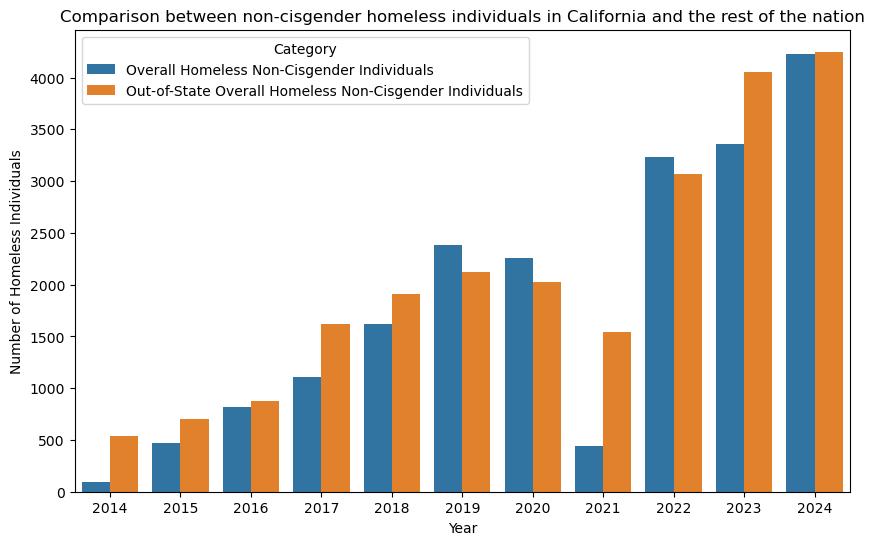

In [182]:
plt.figure(figsize=(10, 6))
sns.barplot(data=ca_noncis_counts_long,x='Year',y='Number of Homeless Individuals',hue='Category')
plt.title('Comparison between non-cisgender homeless individuals in California and the rest of the nation')

When looking at the California non-cisgender homeless population compared to the rest of the United States, I was shocked to see how much of this total population resided in California alone. Looking at the figure above, the amount of non-cisgender homeless individuals in California surpassed the rest of the nation's count in the years 2019, 2020, and 2022. Upon seeing this, I decided to hone my research on the non-cisgender homeless individual population.
  
  
In 2022, [California passed a bill](https://www.nbcnews.com/nbc-out/out-politics-and-policy/california-governor-signs-bill-offering-legal-refuge-transgender-youth-rcna50240) to protect transgender youth that flee their state to California if they were restricted access to transgender healthcare.
  
  
This is one instance in which California has taken steps to protect non-cisgender people, but it seems as though there is more that could be done to catch them when things go wrong. In California they are more likely to be able to safely access the care that they need, which might explain the fact that they represent such a large portion of the population.
___

# Overall Conclusions

### California: 
- The overall population of homeless individuals in California has increased by **77.87** percent from 2014 to 2024
  
- The population of non-cisgender homeless individuals in California has increased by **4542.86** percent from 2014 to 2024. 
  - Both of these are **higher** rates of growth than the United States overall
  
  
### Nationwide:
- Homelessness in the United States is steadily rising, increasing year after year
  
- The overall population of homeless individuals has increased by **42.15** percent from 2014 to 2024
  
- The population of non-cisgender homeless individuals has increased by **1255.84** percent from 2014 to 2024. 
  - There has been a rise in anti-LGBTQ+ legislation in the last decade, which could potentially be a factor in the steep rise in non-cisgender homelessness. Protections against this type of harmful legislation could potentially lead to a decrease in this growth.
  
- HMIS has been increasing their beds in shelters over the years, however the average percent of unsheltered homeless individuals amounted to 45 percent of the population of homeless individuals. 
  - This might suggest that there should be more CoCs in order to house more of the unsheltered homeless individuals. This would require more funding and manpower.
  

## In conclusion:
When I started my research, I initially planned to look at how the homeless population had changed from 2014 to 2024. As I looked at the categories within the data, I decided to hone in on gender as a point of research. My findings showed me that non-cisgender identities make up a very small fraction of homeless individuals, but I wanted to look deeper. Upon looking deeper, it became clear that the amount of non-cisgender homeless individuals is increasing at a startling rate. More steps should be taken to slow down this particular increase in population at the legislative level, especially as transgender individuals are being made the target of anti-transgender legislation.
  